In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/hdd/aouadt/these/projets/3d_segm


In [95]:
from typing import Tuple
from time import time

from PIL import Image, ImageDraw
import torch
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import convolve
import skimage.morphology as morp

from deep_morpho.models.bimonn_axspa import BimonnAxspaPipeline, BimonnAxspaFromSegm
from general.utils import set_borders_to

from deep_morpho.datasets.utils import (
    rand_shape_2d,
    invert_proba,
    get_rect_vertices,
    draw_poly,
    draw_ellipse
)


# Model

In [100]:
# model = BimonnAxspaPipeline()
model = BimonnAxspaFromSegm()

img = torch.rand(1, 2, 256, 256)
otp = model(img)

/hdd/aouadt/these/projets/3d_segm/deep_morpho/models/bisel.py:21: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  m = x // div1


# SpaLike Dataset

In [54]:
def get_random_rotated_diskorect(
    size: Tuple, n_shapes: int = 30, max_shape: Tuple[int] = (15, 15), p_invert: float = 0.5,
        border=(0, 0), n_holes: int = 15, max_shape_holes: Tuple[int] = (5, 5), noise_proba=0.05,
        rng_float=np.random.rand, rng_int=np.random.randint, **kwargs
):
    diskorect = np.zeros(size)
    img = Image.fromarray(diskorect)
    draw = ImageDraw.Draw(img)

    def draw_shape(max_shape, fill_value):
        x = rng_int(0, size[0] - 2)
        y = rng_int(0, size[0] - 2)

        if rng_float() < .5:
            W = rng_int(1, max_shape[0])
            L = rng_int(1, max_shape[1])

            angle = rng_float() * 45
            draw_poly(draw, get_rect_vertices(x, y, W, L, angle), fill_value=fill_value)

        else:
            rx = rng_int(1, max_shape[0]//2)
            ry = rng_int(1, max_shape[1]//2)
            draw_ellipse(draw, np.array([x, y]), (rx, ry), fill_value=fill_value)

    for _ in range(n_shapes):
        draw_shape(max_shape=max_shape, fill_value=1)

    for _ in range(n_holes):
        draw_shape(max_shape=max_shape_holes, fill_value=0)

    diskorect = np.asarray(img) + 0
    diskorect[rand_shape_2d(diskorect.shape, rng_float=rng_float) < noise_proba] = 1  # bernoulli noise
    diskorect = invert_proba(diskorect, p_invert, rng_float=rng_float)  # random invert

    diskorect = set_borders_to(diskorect, border, value=0)

    return diskorect

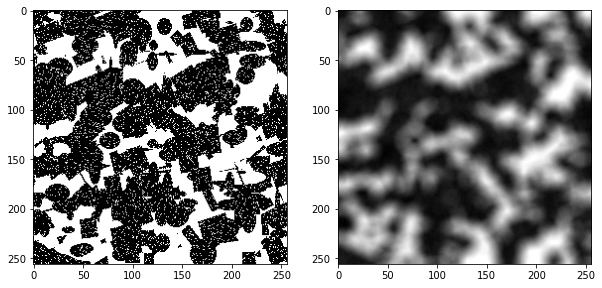

In [94]:
img = get_random_rotated_diskorect(
    (256, 256), 
    n_shapes=300, 
    max_shape=(60, 40), 
    max_shape_holes=(30, 30), 
    n_holes=300, 
    noise_proba=0.1, 
    p_invert=0, 
)
fimg = convolve(img, morp.disk(9))

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(img, cmap="gray")

plt.subplot(122)
plt.imshow(fimg, cmap="gray")

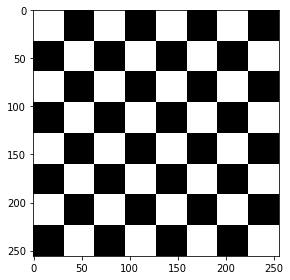

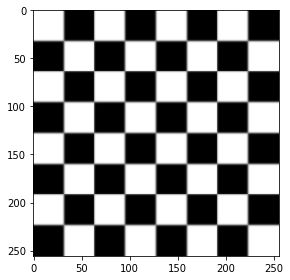

In [2]:
from skimage import data, io, color
import numpy as np


texture = np.kron([[1, 0] * 4, [0, 1] * 4] * 4, np.ones((32, 32)))
io.imshow(texture, cmap='gray')
io.show()
from skimage.filters import gaussian

# Apply Gaussian blur to the texture
blurred_texture = gaussian(texture, sigma=1)

io.imshow(blurred_texture, cmap='gray')
io.show()
